In [1]:
from __future__ import print_function

import collections
import io
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython import display
from sklearn import metrics

tf.logging.set_verbosity(tf.logging.ERROR)
train_url = 'https://storage.googleapis.com/mledu-datasets/sparse-data-embedding/train.tfrecord'
train_path = tf.keras.utils.get_file(train_url.split('/')[-1], train_url)
test_url = 'https://storage.googleapis.com/mledu-datasets/sparse-data-embedding/test.tfrecord'
test_path = tf.keras.utils.get_file(test_url.split('/')[-1], test_url)

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def _parse_function(record):
  """Extracts features and labels.
  
  Args:
    record: File path to a TFRecord file    
  Returns:
    A `tuple` `(labels, features)`:
      features: A dict of tensors representing the features
      labels: A tensor with the corresponding labels.
  """
  features = {
    "terms": tf.VarLenFeature(dtype=tf.string), # terms are strings of varying lengths
    "labels": tf.FixedLenFeature(shape=[1], dtype=tf.float32) # labels are 0 or 1
  }
  
  parsed_features = tf.parse_single_example(record, features)
  
  terms = parsed_features['terms'].values
  labels = parsed_features['labels']

  return  {'terms':terms}, labels

In [3]:
# Create the Dataset object.
ds = tf.data.TFRecordDataset(train_path)
# Map features and labels with the parse function.
ds = ds.map(_parse_function)

ds

<MapDataset shapes: ({terms: (?,)}, (1,)), types: ({terms: tf.string}, tf.float32)>

In [4]:
n = ds.make_one_shot_iterator().get_next()
sess = tf.Session()
sess.run(n)

({'terms': array([b'but', b'it', b'does', b'have', b'some', b'good', b'action',
         b'and', b'a', b'plot', b'that', b'is', b'somewhat', b'interesting',
         b'.', b'nevsky', b'acts', b'like', b'a', b'body', b'builder',
         b'and', b'he', b'isn', b"'", b't', b'all', b'that', b'attractive',
         b',', b'in', b'fact', b',', b'imo', b',', b'he', b'is', b'ugly',
         b'.', b'(', b'his', b'acting', b'skills', b'lack', b'everything',
         b'!', b')', b'sascha', b'is', b'played', b'very', b'well', b'by',
         b'joanna', b'pacula', b',', b'but', b'she', b'needed', b'more',
         b'lines', b'than', b'she', b'was', b'given', b',', b'her',
         b'character', b'needed', b'to', b'be', b'developed', b'.',
         b'there', b'are', b'way', b'too', b'many', b'men', b'in', b'this',
         b'story', b',', b'there', b'is', b'zero', b'romance', b',', b'too',
         b'much', b'action', b',', b'and', b'way', b'too', b'dumb', b'of',
         b'an', b'ending', b'.', b'

In [32]:
# Create an input_fn that parses the tf.Examples from the given files,
# and split them into features and targets.
def _input_fn(input_filenames, num_epochs=None, shuffle=True):
  
  # Same code as above; create a dataset and map features and labels.
  ds = tf.data.TFRecordDataset(input_filenames)
  ds = ds.map(_parse_function)

  if shuffle:
    ds = ds.shuffle(10000)

  # Our feature data is variable-length, so we pad and batch
  # each field of the dataset structure to whatever size is necessary.
  ds = ds.padded_batch(25, ds.output_shapes)
  
  ds = ds.repeat(num_epochs)

  
  # Return the next batch of data.
  features, labels = ds.make_one_shot_iterator().get_next()
  return features, labels

In [ ]:
# 50 informative terms that compose our model vocabulary 
informative_terms = ("bad", "great", "best", "worst", "fun", "beautiful",
                     "excellent", "poor", "boring", "awful", "terrible",
                     "definitely", "perfect", "liked", "worse", "waste",
                     "entertaining", "loved", "unfortunately", "amazing",
                     "enjoyed", "favorite", "horrible", "brilliant", "highly",
                     "simple", "annoying", "today", "hilarious", "enjoyable",
                     "dull", "fantastic", "poorly", "fails", "disappointing",
                     "disappointment", "not", "him", "her", "good", "time",
                     "?", ".", "!", "movie", "film", "action", "comedy",
                     "drama", "family")

In [100]:
terms_feature_column = tf.feature_column.categorical_column_with_vocabulary_list(key="terms", vocabulary_list=informative_terms)

In [33]:
my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

feature_columns = [ terms_feature_column ]


classifier = tf.estimator.LinearClassifier(
  feature_columns=feature_columns,
  optimizer=my_optimizer,
  model_dir='data/model_dir/linear'
)

classifier.train(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([test_path]),
  steps=1000)

print("Test set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

Training set metrics:
accuracy 0.78784
accuracy_baseline 0.5
auc 0.87139326
auc_precision_recall 0.862666
average_loss 0.45101997
label/mean 0.5
loss 11.275499
prediction/mean 0.49560136
global_step 1000
---
Test set metrics:
accuracy 0.78392
accuracy_baseline 0.5
auc 0.8689901
auc_precision_recall 0.8594011
average_loss 0.45290294
label/mean 0.5
loss 11.322574
prediction/mean 0.49396253
global_step 1000
---


In [104]:
tf.train.list_variables('data/model_dir/linear')

[('global_step', []),
 ('linear/linear_model/bias_weights', [1]),
 ('linear/linear_model/bias_weights/part_0/Adagrad', [1]),
 ('linear/linear_model/terms/weights', [30711, 1]),
 ('linear/linear_model/terms/weights/part_0/Adagrad', [30711, 1])]

In [55]:
classifier.get_variable_names()

['global_step',
 'linear/linear_model/bias_weights',
 'linear/linear_model/bias_weights/part_0/Adagrad',
 'linear/linear_model/terms/weights',
 'linear/linear_model/terms/weights/part_0/Adagrad']

In [35]:
##################### Here's what we changed ##################################
classifier = tf.estimator.DNNClassifier(                                      #
  feature_columns=[tf.feature_column.indicator_column(terms_feature_column)], #
  hidden_units=[20,20],                                                       #
  optimizer=my_optimizer,
  model_dir='data/model_dir'                                                     #
)                                                                             #
###############################################################################

try:
  classifier.train(
    input_fn=lambda: _input_fn([train_path]),
    steps=1000)

  evaluation_metrics = classifier.evaluate(
    input_fn=lambda: _input_fn([train_path]),
    steps=1)
  print("Training set metrics:")
  for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
  print("---")

  evaluation_metrics = classifier.evaluate(
    input_fn=lambda: _input_fn([test_path]),
    steps=1)

  print("Test set metrics:")
  for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
  print("---")
except ValueError as err:
  print(err)

Training set metrics:
accuracy 0.72
accuracy_baseline 0.64
auc 0.8715277
auc_precision_recall 0.7988298
average_loss 0.46621606
label/mean 0.36
loss 11.655401
prediction/mean 0.471188
global_step 1000
---
Test set metrics:
accuracy 0.72
accuracy_baseline 0.56
auc 0.72402596
auc_precision_recall 0.8374517
average_loss 0.6752521
label/mean 0.56
loss 16.881302
prediction/mean 0.47568375
global_step 1000
---


In [78]:
########################## YOUR CODE HERE ######################################
terms_embedding_column = tf.feature_column.embedding_column(terms_feature_column, 2)
feature_columns = [terms_embedding_column]
# emb_opt = tf.train.AdagradOptimizer(learning_rate=.1)
# emb_opt = tf.contrib.estimator.clip_gradients_by_norm(emb_opt, 5.0)

classifier_emb = tf.estimator.DNNClassifier(feature_columns=feature_columns,
                                       hidden_units=[20,20],
                                       optimizer=my_optimizer,
                                       model_dir='data/model_dir/dnn'
                                           )
################################################################################

classifier_emb.train(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)

evaluation_metrics = classifier_emb.evaluate(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

evaluation_metrics = classifier_emb.evaluate(
  input_fn=lambda: _input_fn([test_path]),
  steps=1000)

print("Test set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

Training set metrics:
accuracy 0.79028
accuracy_baseline 0.5
auc 0.8711458
auc_precision_recall 0.8599313
average_loss 0.44886264
label/mean 0.5
loss 11.221566
prediction/mean 0.50336444
global_step 3000
---
Test set metrics:
accuracy 0.78496
accuracy_baseline 0.5
auc 0.8703922
auc_precision_recall 0.8580332
average_loss 0.44998297
label/mean 0.5
loss 11.249575
prediction/mean 0.5033612
global_step 3000
---


In [68]:
tf.train.list_variables('data/model_dir/dnn/')

[('dnn/hiddenlayer_0/bias', [20]),
 ('dnn/hiddenlayer_0/bias/t_0/Adagrad', [20]),
 ('dnn/hiddenlayer_0/kernel', [2, 20]),
 ('dnn/hiddenlayer_0/kernel/t_0/Adagrad', [2, 20]),
 ('dnn/hiddenlayer_1/bias', [20]),
 ('dnn/hiddenlayer_1/bias/t_0/Adagrad', [20]),
 ('dnn/hiddenlayer_1/kernel', [20, 20]),
 ('dnn/hiddenlayer_1/kernel/t_0/Adagrad', [20, 20]),
 ('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights',
  [50, 2]),
 ('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights/t_0/Adagrad',
  [50, 2]),
 ('dnn/logits/bias', [1]),
 ('dnn/logits/bias/t_0/Adagrad', [1]),
 ('dnn/logits/kernel', [20, 1]),
 ('dnn/logits/kernel/t_0/Adagrad', [20, 1]),
 ('global_step', [])]

In [64]:
classifier_emb.get_variable_names()

['dnn/hiddenlayer_0/bias',
 'dnn/hiddenlayer_0/bias/t_0/Adagrad',
 'dnn/hiddenlayer_0/kernel',
 'dnn/hiddenlayer_0/kernel/t_0/Adagrad',
 'dnn/hiddenlayer_1/bias',
 'dnn/hiddenlayer_1/bias/t_0/Adagrad',
 'dnn/hiddenlayer_1/kernel',
 'dnn/hiddenlayer_1/kernel/t_0/Adagrad',
 'dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights',
 'dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights/t_0/Adagrad',
 'dnn/logits/bias',
 'dnn/logits/bias/t_0/Adagrad',
 'dnn/logits/kernel',
 'dnn/logits/kernel/t_0/Adagrad',
 'global_step']

In [70]:
classifier_emb.get_variable_value('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights').shape

(50, 2)

In [73]:
classifier_emb.get_variable_value('dnn/hiddenlayer_0/bias/t_0/Adagrad')

array([3.70717430e+00, 3.56318176e-01, 3.19678802e+01, 4.97188446e+02,
       9.56823059e+02, 1.25975174e+02, 1.87035706e+02, 6.21847778e+02,
       4.39133346e-01, 4.38501190e+02, 3.92453700e-01, 6.49897766e+01,
       4.36379284e-01, 2.10909200e+00, 3.91118286e+02, 4.47625828e+00,
       5.33366919e-01, 4.11251307e-01, 4.65225965e-01, 3.87511383e+02],
      dtype=float32)

In [74]:
classifier_emb.get_variable_value('dnn/hiddenlayer_0/bias')

array([-0.098754  , -0.08799189,  0.18853116,  0.28282598,  0.17448923,
        0.08026265,  0.33480424,  0.34867716, -0.10310753,  0.08943922,
       -0.22466135,  0.09749097, -0.11584431, -0.07575903,  0.10598472,
       -0.09442057, -0.09384649, -0.23686561, -0.18329526,  0.1382795 ],
      dtype=float32)

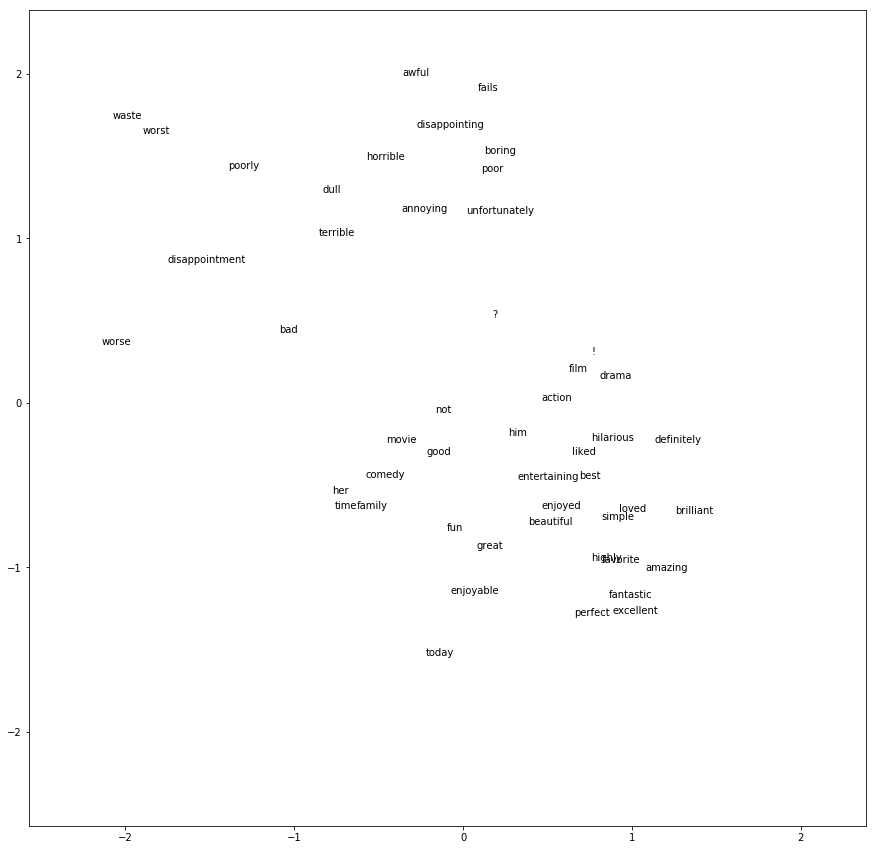

In [79]:
import numpy as np
import matplotlib.pyplot as plt

embedding_matrix = classifier_emb.get_variable_value('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights')

for term_index in range(len(informative_terms)):
  # Create a one-hot encoding for our term. It has 0s everywhere, except for
  # a single 1 in the coordinate that corresponds to that term.
  term_vector = np.zeros(len(informative_terms))
  term_vector[term_index] = 1
  # We'll now project that one-hot vector into the embedding space.
  embedding_xy = np.matmul(term_vector, embedding_matrix)
  plt.text(embedding_xy[0],
           embedding_xy[1],
           informative_terms[term_index])

# Do a little setup to make sure the plot displays nicely.
plt.rcParams["figure.figsize"] = (15, 15)
plt.xlim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.ylim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.show() 

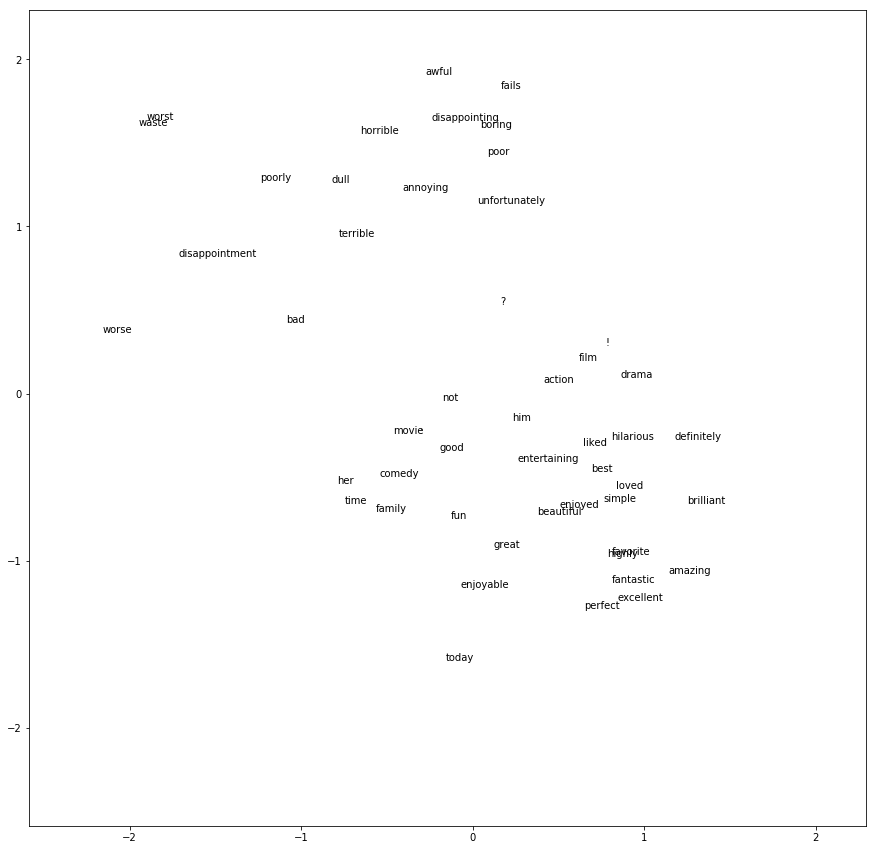

In [77]:
import numpy as np
import matplotlib.pyplot as plt

embedding_matrix = classifier_emb.get_variable_value('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights')

for term_index in range(len(informative_terms)):
  # Create a one-hot encoding for our term. It has 0s everywhere, except for
  # a single 1 in the coordinate that corresponds to that term.
  term_vector = np.zeros(len(informative_terms))
  term_vector[term_index] = 1
  # We'll now project that one-hot vector into the embedding space.
  embedding_xy = np.matmul(term_vector, embedding_matrix)
  plt.text(embedding_xy[0],
           embedding_xy[1],
           informative_terms[term_index])

# Do a little setup to make sure the plot displays nicely.
plt.rcParams["figure.figsize"] = (15, 15)
plt.xlim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.ylim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.show() 

In [81]:
!wget https://storage.googleapis.com/mledu-datasets/sparse-data-embedding/terms.txt -O ./data/terms.txt

--2018-06-21 20:05:16--  https://storage.googleapis.com/mledu-datasets/sparse-data-embedding/terms.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.222.128, 2a00:1450:4010:c0f::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.222.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 253538 (248K) [text/plain]
Saving to: ‘./data/terms.txt’

./data/terms.txt    100%[===================>] 247.60K  1.59MB/s    in 0.2s    

2018-06-21 20:05:17 (1.59 MB/s) - ‘./data/terms.txt’ saved [253538/253538]



In [94]:
# Download the vocabulary file.
terms_url = 'https://storage.googleapis.com/mledu-datasets/sparse-data-embedding/terms.txt'
terms_path = tf.keras.utils.get_file(terms_url.split('/')[-1], terms_url)

253952/253538 [==============================] - 0s 1us/step


In [97]:
len(informative_terms[::3])

10237

In [95]:
# Create a feature column from "terms", using a full vocabulary file.
informative_terms = None
with io.open(terms_path, 'r', encoding='utf8') as f:
  # Convert it to a set first to remove duplicates.
  informative_terms = list(set(f.read().split()))
  
terms_feature_column = tf.feature_column.categorical_column_with_vocabulary_list(key="terms", 
                                                                                 vocabulary_list=informative_terms)

terms_embedding_column = tf.feature_column.embedding_column(terms_feature_column, dimension=2)
feature_columns = [ terms_embedding_column ]

my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

classifier = tf.estimator.DNNClassifier(
  feature_columns=feature_columns,
  hidden_units=[10,10],
  optimizer=my_optimizer
)

classifier.train(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([test_path]),
  steps=1000)

print("Test set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

Training set metrics:
accuracy 0.82876
accuracy_baseline 0.5
auc 0.90633345
auc_precision_recall 0.90333533
average_loss 0.38967022
label/mean 0.5
loss 9.7417555
prediction/mean 0.51726073
global_step 1000
---
Test set metrics:
accuracy 0.81332
accuracy_baseline 0.5
auc 0.893895
auc_precision_recall 0.8905452
average_loss 0.41324052
label/mean 0.5
loss 10.331013
prediction/mean 0.51372135
global_step 1000
---


In [99]:
# Create a feature column from "terms", using a full vocabulary file.
informative_terms = None
with io.open(terms_path, 'r', encoding='utf8') as f:
  # Convert it to a set first to remove duplicates.
  informative_terms = list(set(f.read().split()))
  
terms_feature_column = tf.feature_column.categorical_column_with_vocabulary_list(key="terms", 
                                                                                 vocabulary_list=informative_terms)

terms_embedding_column = tf.feature_column.embedding_column(terms_feature_column, dimension=10)
feature_columns = [ terms_embedding_column ]

my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

classifier = tf.estimator.DNNClassifier(
  feature_columns=feature_columns,
  hidden_units=[10,10],
  optimizer=my_optimizer
)

classifier.train(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([train_path]),
  steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([test_path]),
  steps=1000)

print("Test set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

Training set metrics:
accuracy 0.86956
accuracy_baseline 0.5
auc 0.93945175
auc_precision_recall 0.9369658
average_loss 0.3190333
label/mean 0.5
loss 7.9758325
prediction/mean 0.5254478
global_step 1000
---
Test set metrics:
accuracy 0.84704
accuracy_baseline 0.5
auc 0.9239096
auc_precision_recall 0.92056435
average_loss 0.35561672
label/mean 0.5
loss 8.890418
prediction/mean 0.5247382
global_step 1000
---


# Shuffle word order

In [21]:
def _parse_function_shuffle(record):
  """Extracts features and labels.
  
  Args:
    record: File path to a TFRecord file    
  Returns:
    A `tuple` `(labels, features)`:
      features: A dict of tensors representing the features
      labels: A tensor with the corresponding labels.
  """
  features = {
    "terms": tf.VarLenFeature(dtype=tf.string), # terms are strings of varying lengths
    "labels": tf.FixedLenFeature(shape=[1], dtype=tf.float32) # labels are 0 or 1
  }
  
  parsed_features = tf.parse_single_example(record, features)
  
  terms = tf.random_shuffle(parsed_features['terms'].values, seed=442)
#   print(type(terms))
#   np.random.shuffle(terms)
  labels = parsed_features['labels']

  return  {'terms':terms}, labels

In [36]:
# Create the Dataset object.
ds = tf.data.TFRecordDataset(train_path)
# Map features and labels with the parse function.
ds = ds.map(_parse_function_shuffle)

ds

<MapDataset shapes: ({terms: (?,)}, (1,)), types: ({terms: tf.string}, tf.float32)>

In [37]:
n = ds.make_one_shot_iterator().get_next()
sess = tf.Session()
sess.run(n)

({'terms': array([b'plot', b'world', b'will', b'but', b'nor', b'to', b'this', b'way',
         b'have', b'is', b'played', b'acting', b"'", b'was', b'.', b'an',
         b'had', b'too', b'is', b'the', b'dumb', b'movie', b'normal',
         b'builder', b'action', b'normal', b',', b'action', b'skills', b'.',
         b'.', b'men', b'a', b't', b'well', b'she', b'biggest', b'imo',
         b'hot', b'enough', b'this', b',', b',', b'there', b'the', b'of',
         b'.', b'isn', b'given', b'mafia', b'does', b'cut', b'to', b'it',
         b'.', b'attention', b'.', b'too', b'the', b'i', b'sascha', b'is',
         b'takes', b'it', b'joanna', b'and', b'it', b'attractive', b"'",
         b'or', b'us', b'fact', b'got', b'lack', b'all', b'all', b',',
         b'doesn', b'and', b'be', b'handsome', b'over', b'movie', b',',
         b'by', b'and', b't', b'it', b'than', b'this', b'ending', b"'",
         b'needed', b'sexy', b'there', b'too', b'!', b'it', b'nevsky', b',',
         b'action', b'be', b'that

In [28]:
# Create an input_fn that parses the tf.Examples from the given files,
# and split them into features and targets.
def _input_fn_shuffle(input_filenames, num_epochs=None, shuffle=True):
  
  # Same code as above; create a dataset and map features and labels.
  ds = tf.data.TFRecordDataset(input_filenames)
  ds = ds.map(_parse_function_shuffle)

  if shuffle:
    ds = ds.shuffle(10000)

  # Our feature data is variable-length, so we pad and batch
  # each field of the dataset structure to whatever size is necessary.
  ds = ds.padded_batch(25, ds.output_shapes)
  
  ds = ds.repeat(num_epochs)

  
  # Return the next batch of data.
  features, labels = ds.make_one_shot_iterator().get_next()
  return features, labels

In [29]:
# 50 informative terms that compose our model vocabulary 
informative_terms = ("bad", "great", "best", "worst", "fun", "beautiful",
                     "excellent", "poor", "boring", "awful", "terrible",
                     "definitely", "perfect", "liked", "worse", "waste",
                     "entertaining", "loved", "unfortunately", "amazing",
                     "enjoyed", "favorite", "horrible", "brilliant", "highly",
                     "simple", "annoying", "today", "hilarious", "enjoyable",
                     "dull", "fantastic", "poorly", "fails", "disappointing",
                     "disappointment", "not", "him", "her", "good", "time",
                     "?", ".", "!", "movie", "film", "action", "comedy",
                     "drama", "family")

In [30]:
terms_feature_column = tf.feature_column.categorical_column_with_vocabulary_list(key="terms", vocabulary_list=informative_terms)

In [46]:
my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

feature_columns = [ terms_feature_column ]


classifier = tf.estimator.LinearClassifier(
  feature_columns=feature_columns,
  optimizer=my_optimizer,
  model_dir='data/model_dir/linear'
)

classifier.train(
  input_fn=lambda: _input_fn_shuffle([train_path]),
  steps=1000)

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn_shuffle([train_path]),
  steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

evaluation_metrics = classifier.evaluate(
  input_fn=lambda: _input_fn([test_path]),
  steps=1000)

print("Test set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

Training set metrics:
accuracy 0.79044
accuracy_baseline 0.5
auc 0.8734751
auc_precision_recall 0.8650465
average_loss 0.44807667
label/mean 0.5
loss 11.201917
prediction/mean 0.4927893
global_step 4000
---
Test set metrics:
accuracy 0.78568
accuracy_baseline 0.5
auc 0.8714489
auc_precision_recall 0.86252797
average_loss 0.44946197
label/mean 0.5
loss 11.236548
prediction/mean 0.4919817
global_step 4000
---


In [52]:
##################### Here's what we changed ##################################
classifier = tf.estimator.DNNClassifier(                                      #
  feature_columns=[tf.feature_column.indicator_column(terms_feature_column)], #
  hidden_units=[20,20],                                                       #
  optimizer=my_optimizer,
  model_dir='data/model_dir'                                                     #
)                                                                             #
###############################################################################

try:
  classifier.train(
    input_fn=lambda: _input_fn_shuffle([train_path]),
    steps=1000)

  evaluation_metrics = classifier.evaluate(
    input_fn=lambda: _input_fn_shuffle([train_path]),
    steps=1000)
  print("Training set metrics:")
  for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
  print("---")

  evaluation_metrics = classifier.evaluate(
    input_fn=lambda: _input_fn([test_path]),
    steps=1000)

  print("Test set metrics:")
  for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
  print("---")
except ValueError as err:
  print(err)

Training set metrics:
accuracy 0.7916
accuracy_baseline 0.5
auc 0.88010305
auc_precision_recall 0.8720004
average_loss 0.43761587
label/mean 0.5
loss 10.940396
prediction/mean 0.52669406
global_step 6000
---
Test set metrics:
accuracy 0.78684
accuracy_baseline 0.5
auc 0.8754657
auc_precision_recall 0.865956
average_loss 0.44524202
label/mean 0.5
loss 11.131051
prediction/mean 0.52507305
global_step 6000
---


In [53]:
########################## YOUR CODE HERE ######################################
terms_embedding_column = tf.feature_column.embedding_column(terms_feature_column, 2)
feature_columns = [terms_embedding_column]
# emb_opt = tf.train.AdagradOptimizer(learning_rate=.1)
# emb_opt = tf.contrib.estimator.clip_gradients_by_norm(emb_opt, 5.0)

classifier_emb = tf.estimator.DNNClassifier(feature_columns=feature_columns,
                                       hidden_units=[20,20],
                                       optimizer=my_optimizer,
                                       model_dir='data/model_dir/dnn'
                                           )
################################################################################

classifier_emb.train(
  input_fn=lambda: _input_fn_shuffle([train_path]),
  steps=1000)

evaluation_metrics = classifier_emb.evaluate(
  input_fn=lambda: _input_fn_shuffle([train_path]),
  steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

evaluation_metrics = classifier_emb.evaluate(
  input_fn=lambda: _input_fn([test_path]),
  steps=1000)

print("Test set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

Training set metrics:
accuracy 0.78512
accuracy_baseline 0.5
auc 0.8677584
auc_precision_recall 0.8556496
average_loss 0.4549846
label/mean 0.5
loss 11.374616
prediction/mean 0.51133454
global_step 1000
---
Test set metrics:
accuracy 0.78248
accuracy_baseline 0.5
auc 0.86742806
auc_precision_recall 0.8546642
average_loss 0.4551947
label/mean 0.5
loss 11.3798685
prediction/mean 0.51050776
global_step 1000
---


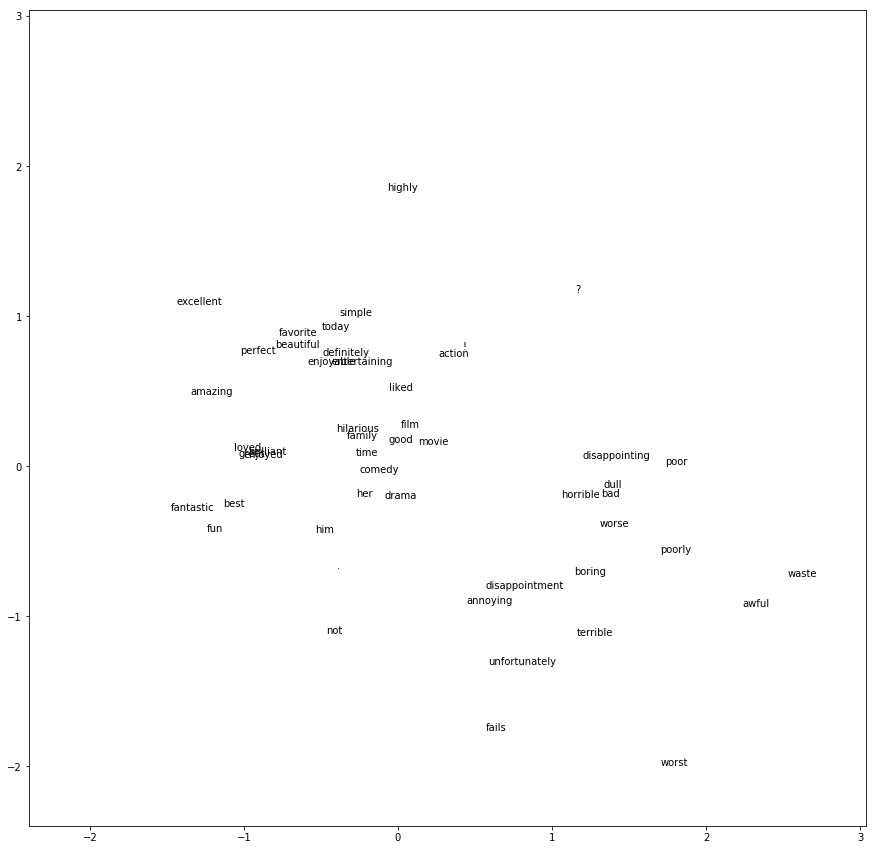

In [55]:
import numpy as np
import matplotlib.pyplot as plt

embedding_matrix = classifier_emb.get_variable_value('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights')

for term_index in range(len(informative_terms)):
  # Create a one-hot encoding for our term. It has 0s everywhere, except for
  # a single 1 in the coordinate that corresponds to that term.
  term_vector = np.zeros(len(informative_terms))
  term_vector[term_index] = 1
  # We'll now project that one-hot vector into the embedding space.
  embedding_xy = np.matmul(term_vector, embedding_matrix)
  plt.text(embedding_xy[0],
           embedding_xy[1],
           informative_terms[term_index])

# Do a little setup to make sure the plot displays nicely.
plt.rcParams["figure.figsize"] = (15, 15)
plt.xlim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.ylim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.show() 

In [58]:
########################## YOUR CODE HERE ######################################
terms_embedding_column = tf.feature_column.embedding_column(terms_feature_column, 2)
feature_columns = [terms_embedding_column]
# emb_opt = tf.train.AdagradOptimizer(learning_rate=.1)
# emb_opt = tf.contrib.estimator.clip_gradients_by_norm(emb_opt, 5.0)

classifier_emb = tf.estimator.DNNClassifier(feature_columns=feature_columns,
                                       hidden_units=[20,20],
                                       optimizer=my_optimizer,
                                       model_dir='data/model_dir/dnn'
                                           )
################################################################################

classifier_emb.train(
  input_fn=lambda: _input_fn_shuffle([train_path]),
  steps=1000)

evaluation_metrics = classifier_emb.evaluate(
  input_fn=lambda: _input_fn_shuffle([train_path]),
  steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

evaluation_metrics = classifier_emb.evaluate(
  input_fn=lambda: _input_fn([test_path]),
  steps=1000)

print("Test set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---")

Training set metrics:
accuracy 0.78884
accuracy_baseline 0.5
auc 0.87144536
auc_precision_recall 0.8599787
average_loss 0.4483266
label/mean 0.5
loss 11.208165
prediction/mean 0.5146697
global_step 3000
---
Test set metrics:
accuracy 0.7852
accuracy_baseline 0.5
auc 0.8705197
auc_precision_recall 0.8583643
average_loss 0.44959158
label/mean 0.5
loss 11.239789
prediction/mean 0.51426923
global_step 3000
---


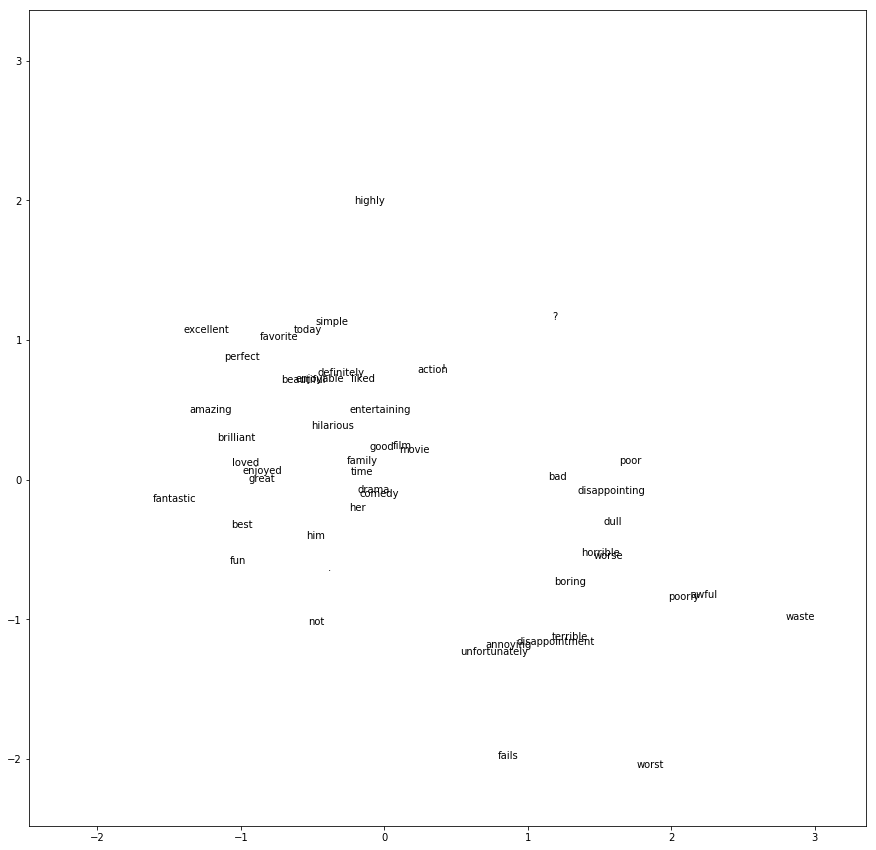

In [59]:
import numpy as np
import matplotlib.pyplot as plt

embedding_matrix = classifier_emb.get_variable_value('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights')

for term_index in range(len(informative_terms)):
  # Create a one-hot encoding for our term. It has 0s everywhere, except for
  # a single 1 in the coordinate that corresponds to that term.
  term_vector = np.zeros(len(informative_terms))
  term_vector[term_index] = 1
  # We'll now project that one-hot vector into the embedding space.
  embedding_xy = np.matmul(term_vector, embedding_matrix)
  plt.text(embedding_xy[0],
           embedding_xy[1],
           informative_terms[term_index])

# Do a little setup to make sure the plot displays nicely.
plt.rcParams["figure.figsize"] = (15, 15)
plt.xlim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.ylim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.show() 